In [1]:
import numpy as np
import pandas as pd
from plotnine import *
from scipy.stats import ttest_ind

In [2]:
PARAMS = [
    "ABSNJZH", "EPSX", "EPSY", "EPSZ", "MEANALP", "MEANGAM", "MEANGBH",
    "MEANGBT", "MEANGBZ", "MEANJZD", "MEANJZH", "MEANPOT", "MEANSHR", "R_VALUE",
    "SAVNCPP", "SHRGT45", "TOTBSQ", "TOTFX", "TOTFY", "TOTFZ", "TOTPOT",
    "TOTUSJH", "TOTUSJZ", "USFLUX"
]

In [3]:
def do_t_test(
        x: pd.Series, flare_flags: pd.Series, *, equal_var: bool = True
    ) -> float:
    result = ttest_ind(x[flare_flags], x[~flare_flags], equal_var=equal_var)
    return result.statistic**2

def calc_all_fisher_scores(partition: int) -> pd.DataFrame:
    summary_df = pd.read_parquet(
        f"../../data/processed/partition{partition}/summary_df.parquet"
    )
    corrected_summary_df = pd.read_parquet(
        f"../../data/processed/partition{partition}/corrected_summary_df.parquet"
    )

    fisher_scores = (
        summary_df
        .drop(columns=["partition", "type", "flare_class", "ar_num", "file"])
        .apply(lambda x: do_t_test(x, summary_df["type"] == "FL"))
        .reset_index(name="Score")
        .rename(columns={"index": "Specs"})
    )
    corrected_fisher_scores = (
        corrected_summary_df
        .drop(columns=["partition", "type", "flare_class", "ar_num", "file"])
        .apply(lambda x: do_t_test(x, corrected_summary_df["type"] == "FL"))
        .reset_index(name="CORR_Score")
        .rename(columns={"index": "CORR_Specs"})
        .assign(
            CORR_Specs=lambda df: (
                df["CORR_Specs"]
                .str.replace(
                    "^(R_VALUE|[A-Z0-9]+)_", r"\1_CORRECTED_", regex=True
                )
            )
        )
    )
    all_fisher_scores = (
        pd.concat([fisher_scores, corrected_fisher_scores], axis=1)
        .assign(
            IMP=lambda x: x["CORR_Score"] - x["Score"],
            Best_Score=lambda x: x["Score"].combine(x["CORR_Score"], max)
        )
        .sort_values("Best_Score", ascending=False, ignore_index=True)
    )

    return all_fisher_scores

In [4]:
all_fisher_scores = []
improvements = []
for partition in range(1, 6):
    all_fisher_scores.append(calc_all_fisher_scores(partition))
    improvements.append(
        pd.read_csv(f"../../Partition{partition}Improvements.csv")
    )
    print(all_fisher_scores[partition - 1].equals(improvements[partition - 1]))

False
False
False
False
False


In [5]:
all_fisher_scores[0].head()

,Specs,Score,CORR_Specs,CORR_Score,IMP,Best_Score
0,ABSNJZH_max,18327.774353,ABSNJZH_CORRECTED_max,17591.465395,-736.308958,18327.774353
1,ABSNJZH_last_value,18049.456903,ABSNJZH_CORRECTED_last_value,17286.115323,-763.341580,18049.456903
2,SAVNCPP_max,16920.760643,SAVNCPP_CORRECTED_max,17220.596348,299.835705,17220.596348
3,SAVNCPP_last_value,16592.883968,SAVNCPP_CORRECTED_last_value,16775.566490,182.682521,16775.566490
4,ABSNJZH_mean,16655.129744,ABSNJZH_CORRECTED_mean,15832.259120,-822.870624,16655.129744


In [6]:
improvements[0].head()

,Specs,Score,CORR_Specs,CORR_Score,IMP,Best_Score
0,ABSNJZH_max,18327.774353,ABSNJZH_CORRECTED_max,17591.465395,-4.017449,18327.774353
1,ABSNJZH_last_value,18049.456903,ABSNJZH_CORRECTED_last_value,17286.115323,-4.229166,18049.456903
2,SAVNCPP_max,16920.760643,SAVNCPP_CORRECTED_max,17220.596348,1.771999,17220.596348
3,SAVNCPP_last_value,16592.883968,SAVNCPP_CORRECTED_last_value,16775.566490,1.100969,16775.566490
4,ABSNJZH_mean,16655.129744,ABSNJZH_CORRECTED_mean,15832.259690,-4.940640,16655.129744


In [7]:
def make_comparison(
        all_fisher_scores: pd.DataFrame, improvements: pd.DataFrame
    ) -> pd.DataFrame:
    comparison = (
        all_fisher_scores[["Specs", "Score"]]
        .sort_values("Specs", ignore_index=True)
        .merge(
            improvements[["Specs", "Score"]],
            on="Specs", suffixes=["", "_orig"]
        )
        .assign(
            suffix=lambda df: (
                df["Specs"].str.replace("^(R_VALUE|[A-Z0-9]+)_", "", regex=True)
            ),
            diff=lambda df: df["Score"] - df["Score_orig"],
            abs_diff=lambda df: df["diff"].abs(),
            rel_diff=lambda df: df["diff"] / df["Score_orig"],
            abs_rel_diff=lambda df: df["rel_diff"].abs()
        )
    )
    return comparison

def make_comparison_plot(comparison: pd.DataFrame, partition: int) -> ggplot:
    comparison_plot_data = (
        comparison[["suffix", "diff", "abs_diff", "rel_diff", "abs_rel_diff"]]
        .melt(id_vars="suffix", var_name="metric", value_name="val")
        .assign(
            metric=lambda df: (
                pd.Categorical(
                    df["metric"],
                    ["diff", "abs_diff", "rel_diff", "abs_rel_diff"]
                )
            )
        )
    )
    plot = (
        ggplot(comparison_plot_data, aes(x="suffix", y="val")) +
        facet_wrap("metric", scales="free_x") +
        geom_boxplot() +
        coord_flip() +
        ggtitle(f"Partition {partition}") +
        theme_bw()
    )
    return plot

In [8]:
comparisons = []
for partition in range(1, 6):
    comparisons.append(
        make_comparison(
            all_fisher_scores[partition - 1], improvements[partition - 1]
        )
    )

In [9]:
comparisons[0].head()

,Specs,Score,Score_orig,suffix,diff,abs_diff,rel_diff,abs_rel_diff
0,ABSNJZH_gderivative_mean,1219.588175,1193.701604,gderivative_mean,2.588657e+01,2.588657e+01,2.168596e-02,2.168596e-02
1,ABSNJZH_gderivative_stddev,10229.782238,11465.956364,gderivative_stddev,-1.236174e+03,1.236174e+03,-1.078126e-01,1.078126e-01
2,ABSNJZH_kurtosis,30.907237,30.907237,kurtosis,1.080025e-12,1.080025e-12,3.494408e-14,3.494408e-14
3,ABSNJZH_last_value,18049.456903,18049.456903,last_value,-5.093170e-11,5.093170e-11,-2.821786e-15,2.821786e-15
4,ABSNJZH_max,18327.774353,18327.774353,max,-2.110028e-10,2.110028e-10,-1.151273e-14,1.151273e-14


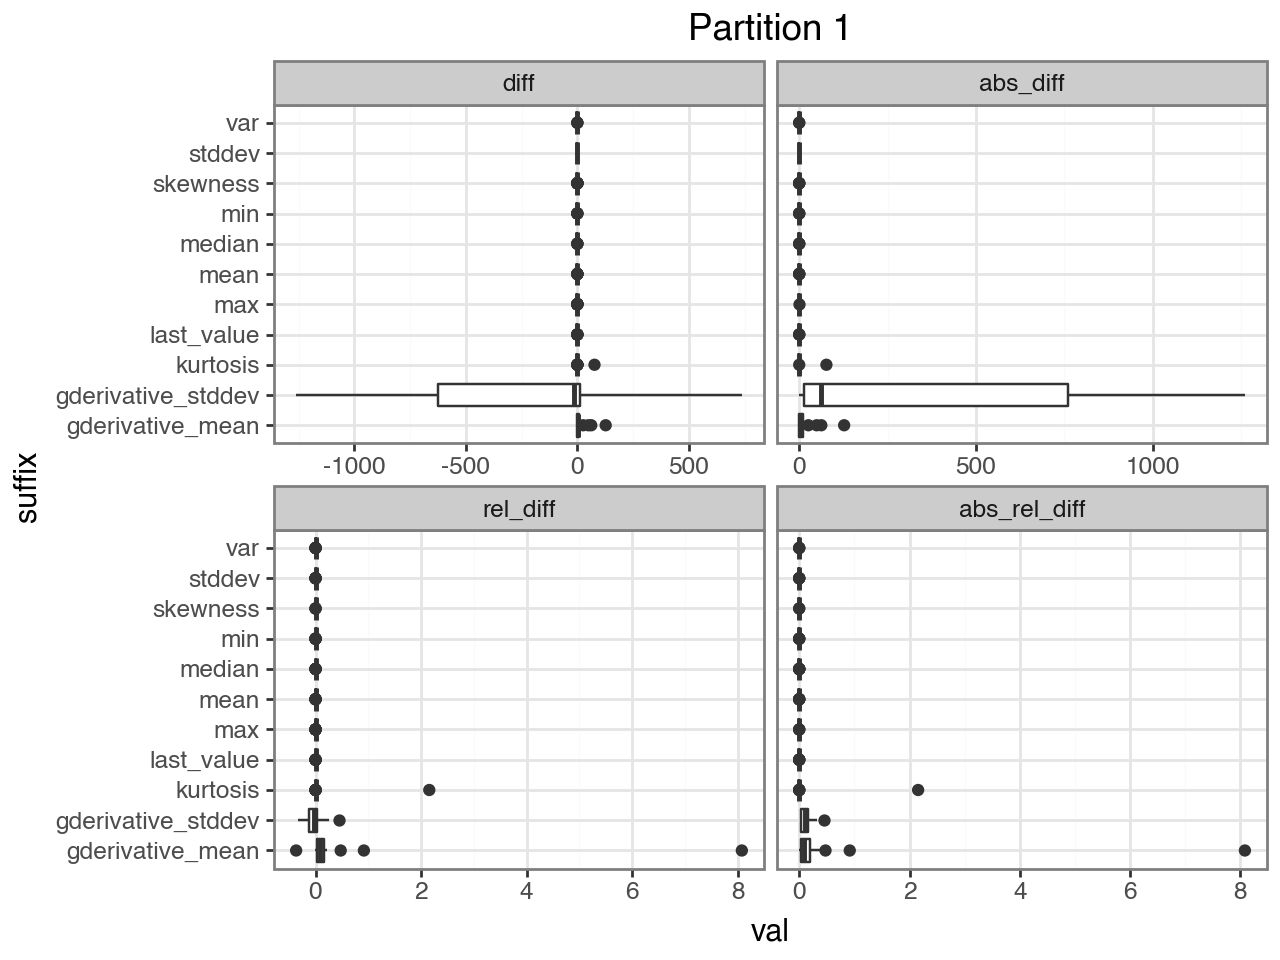

/Users/vkverma/research/Projection-Effects/env/lib/python3.12/site-packages/plotnine/layer.py:293: PlotnineWarning: stat_boxplot : Removed 572 rows containing non-finite values.


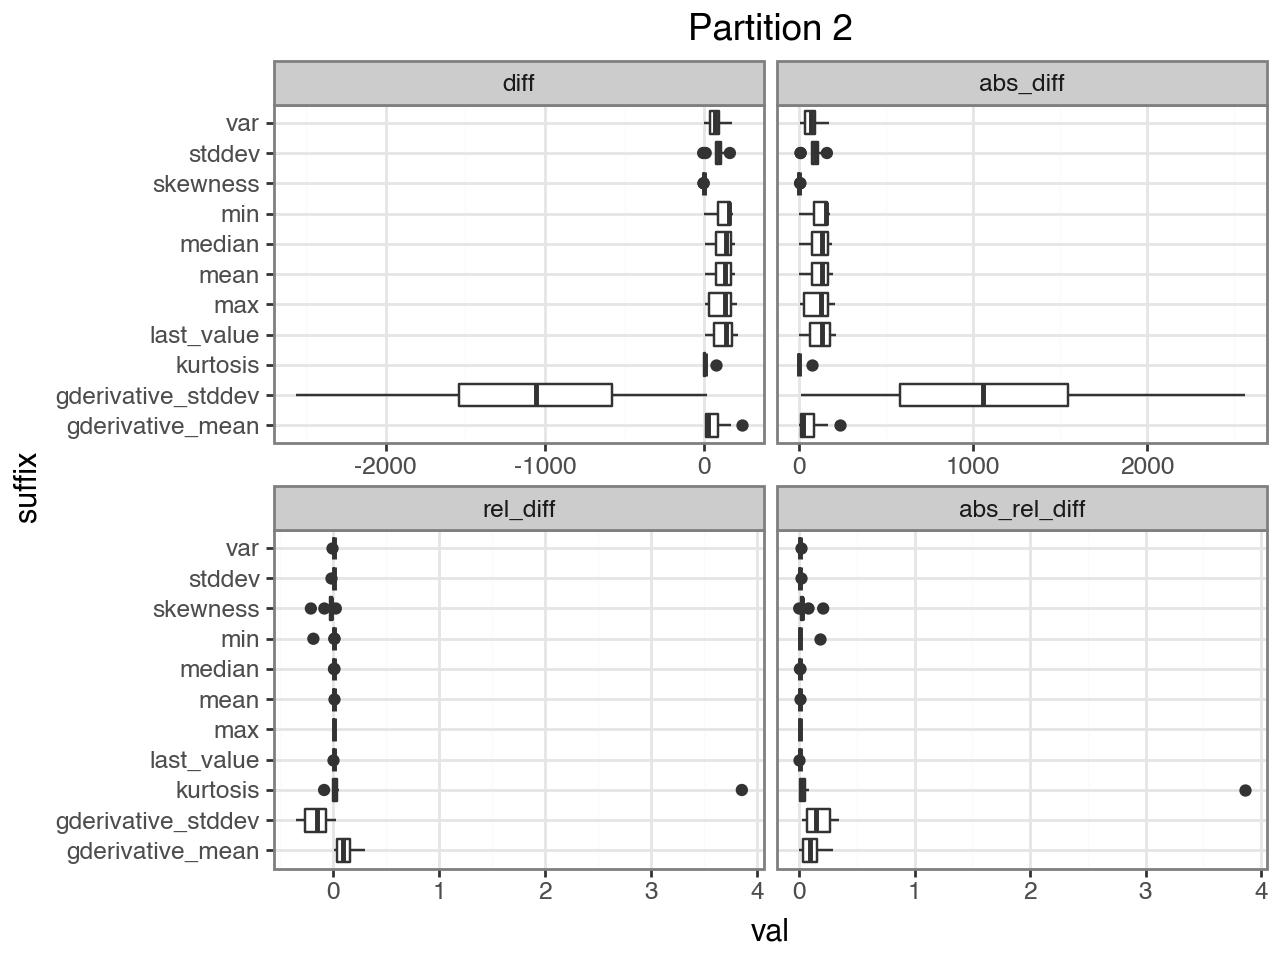

/Users/vkverma/research/Projection-Effects/env/lib/python3.12/site-packages/plotnine/layer.py:293: PlotnineWarning: stat_boxplot : Removed 572 rows containing non-finite values.


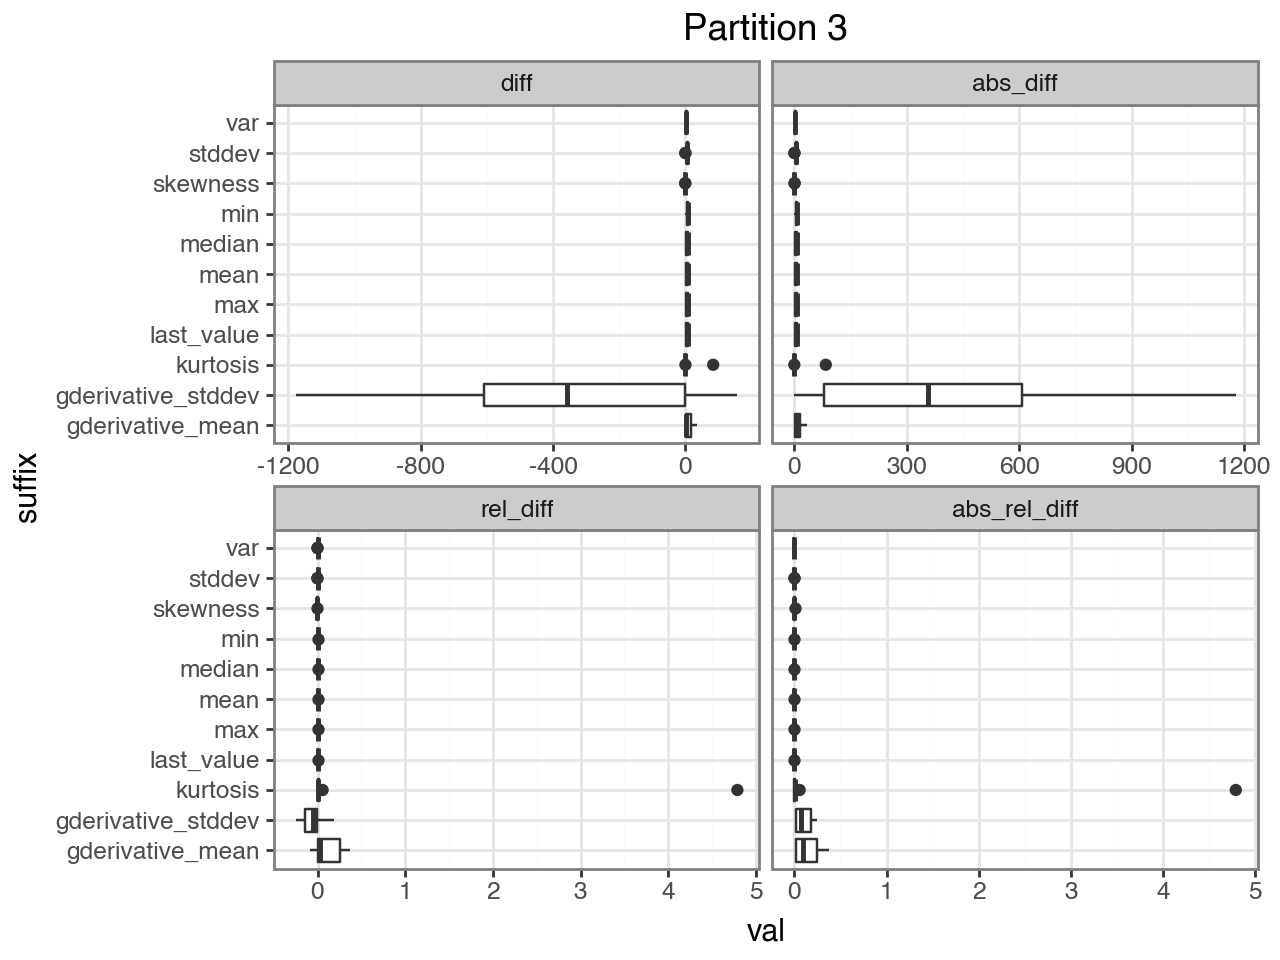

/Users/vkverma/research/Projection-Effects/env/lib/python3.12/site-packages/plotnine/layer.py:293: PlotnineWarning: stat_boxplot : Removed 572 rows containing non-finite values.


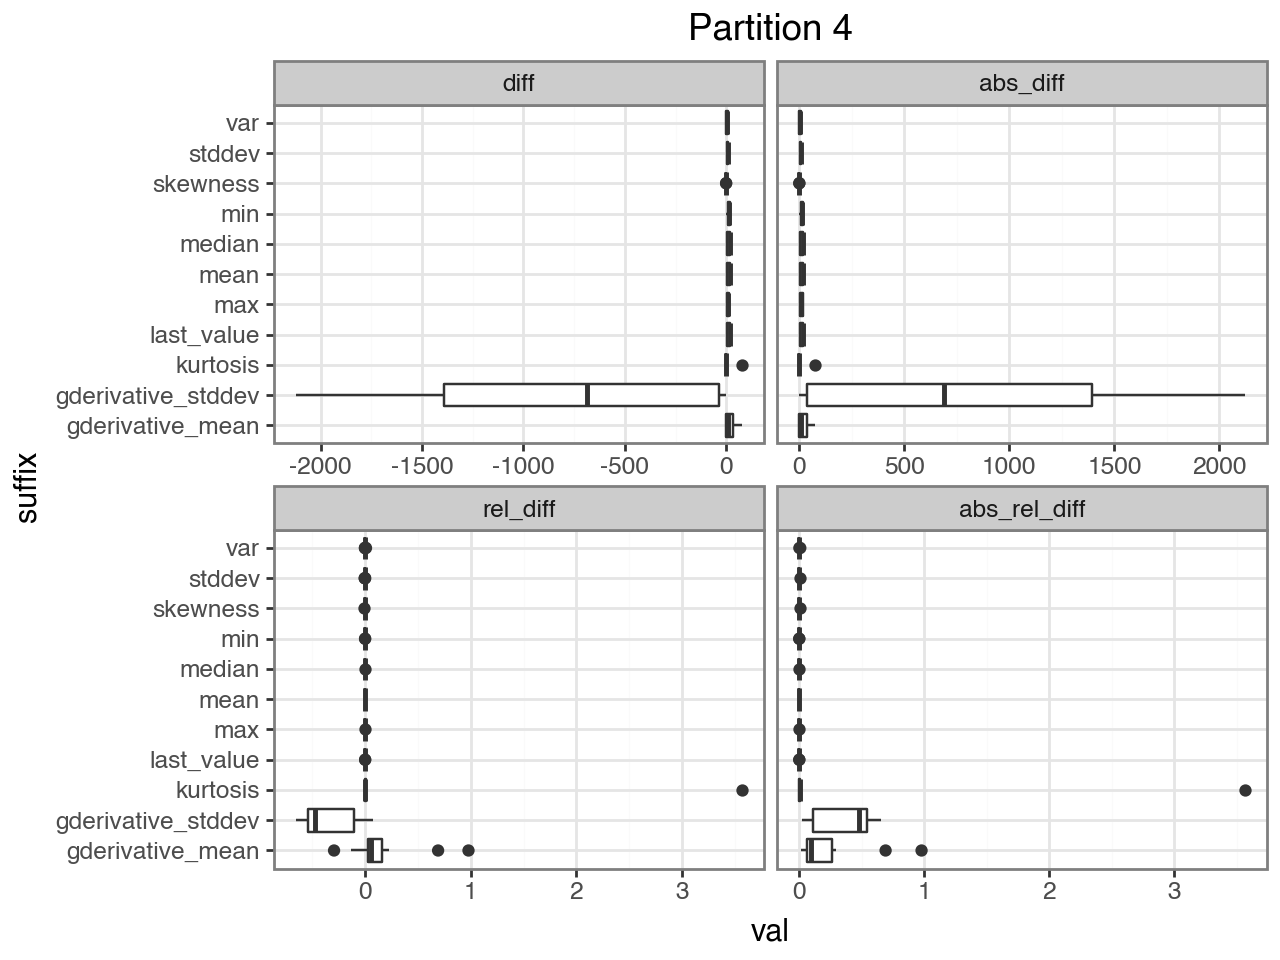

/Users/vkverma/research/Projection-Effects/env/lib/python3.12/site-packages/plotnine/layer.py:293: PlotnineWarning: stat_boxplot : Removed 572 rows containing non-finite values.


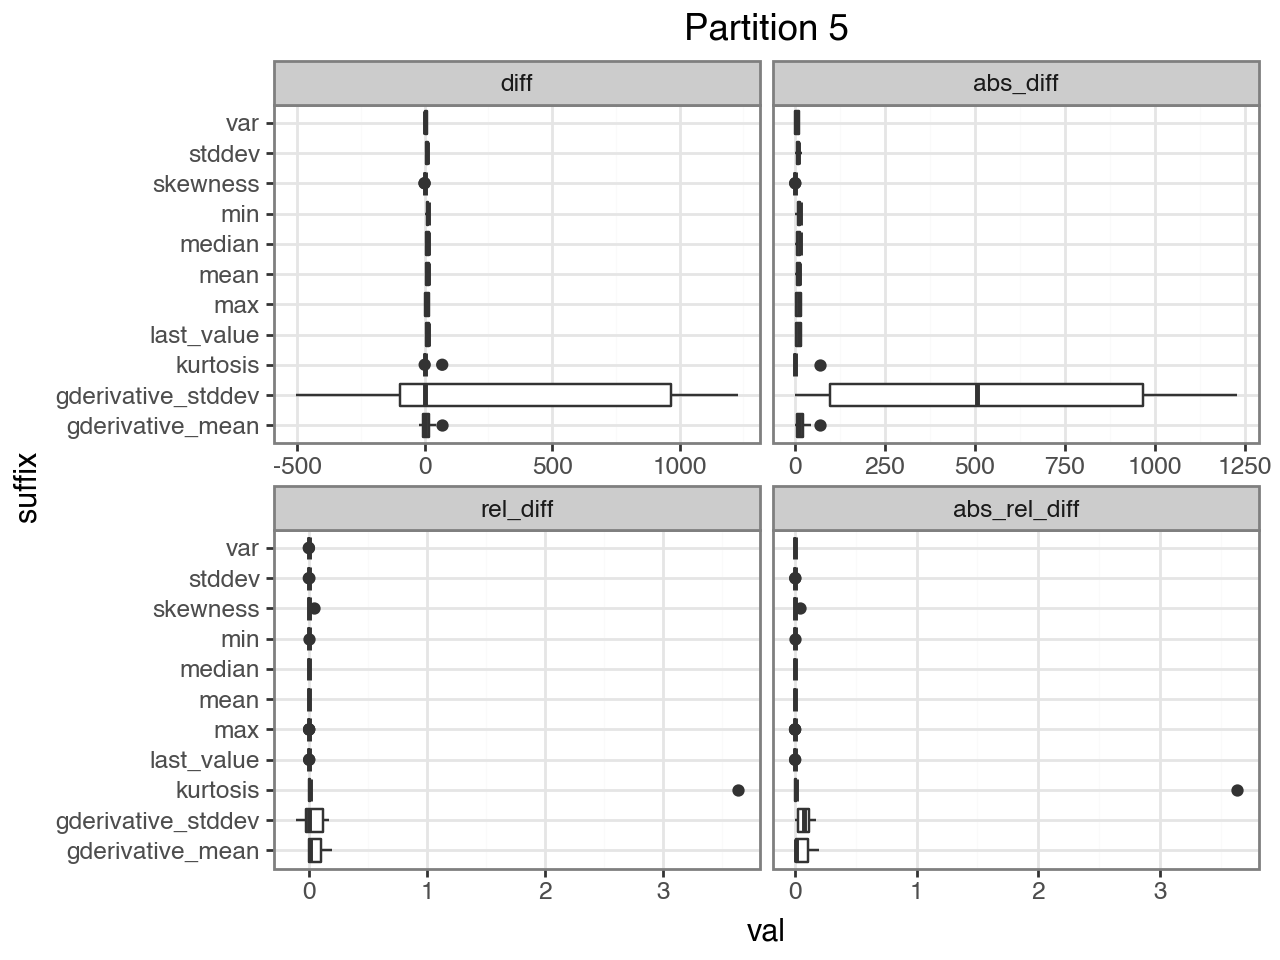

In [10]:
for partition in range(1, 6):
    make_comparison_plot(comparisons[partition - 1], partition).show()

In [11]:
comparisons[0].sort_values("abs_diff", ascending=False)

,Specs,Score,Score_orig,suffix,diff,abs_diff,rel_diff,abs_rel_diff
177,TOTBSQ_gderivative_stddev,4724.374837,5985.141624,gderivative_stddev,-1.260767e+03,1.260767e+03,-2.106494e-01,2.106494e-01
1,ABSNJZH_gderivative_stddev,10229.782238,11465.956364,gderivative_stddev,-1.236174e+03,1.236174e+03,-1.078126e-01,1.078126e-01
254,USFLUX_gderivative_stddev,2500.569138,3559.257316,gderivative_stddev,-1.058688e+03,1.058688e+03,-2.974464e-01,2.974464e-01
232,TOTUSJH_gderivative_stddev,6105.529727,7017.496796,gderivative_stddev,-9.119671e+02,9.119671e+02,-1.299562e-01,1.299562e-01
210,TOTFZ_gderivative_stddev,10017.527752,10915.467080,gderivative_stddev,-8.979393e+02,8.979393e+02,-8.226302e-02,8.226302e-02
...,...,...,...,...,...,...,...,...
125,MEANPOT_max,0.004631,0.004631,max,2.419072e-15,2.419072e-15,5.223293e-13,5.223293e-13
17,EPSX_median,0.270019,0.270019,median,2.331468e-15,2.331468e-15,8.634469e-15,8.634469e-15
16,EPSX_mean,0.250251,0.250251,mean,2.220446e-15,2.220446e-15,8.872872e-15,8.872872e-15
27,EPSY_mean,9.991766,9.991766,mean,1.776357e-15,1.776357e-15,1.777821e-16,1.777821e-16


In [12]:
for partition in range(1, 6):
    all_fisher_scores[partition - 1].to_parquet(
        f"partition{partition}_improvements.parquet"
    )